In [1]:
!git clone https://github.com/ultralytics/yolov5.git

%cd yolov5

!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 18.55 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 14.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#'/content/drive/MyDrive/PROJECT/metaData.json'
#'/content/drive/MyDrive/PROJECT/Images.zip'

Mounted at /content/drive


# **Step 1: Convert COCO Annotations to YOLO Format**

In [12]:
import json
import os
import shutil

# Paths
coco_annotations_path = "/content/drive/MyDrive/PROJECT/instances.json"  # Path to COCO JSON
images_dir = "/content/drive/MyDrive/PROJECT/photos"                    # Directory containing images
output_dir = "/content/yolo_dataset"                                    # Output directory

os.makedirs(f"{output_dir}/images/train", exist_ok=True)
os.makedirs(f"{output_dir}/images/val", exist_ok=True)
os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
os.makedirs(f"{output_dir}/labels/val", exist_ok=True)

# Load COCO annotations
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)

categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
category_ids = {cat_id: i for i, cat_id in enumerate(categories.keys())}

# Split data into train/val
train_ratio = 0.8
images = coco_data['images']
annotations = coco_data['annotations']
train_images = images[:int(len(images) * train_ratio)]
val_images = images[int(len(images) * train_ratio):]


def save_yolo_format(images, annotations, subset):
    for img in images:
        img_id = img['id']
        file_name = img['file_name']
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_id]

        # Define the paths to move images
        subset_img_dir = f"{output_dir}/images/{subset}"
        subset_label_dir = f"{output_dir}/labels/{subset}"
        os.makedirs(subset_img_dir, exist_ok=True)
        os.makedirs(subset_label_dir, exist_ok=True)

        # Move image to the correct subset folder (handling cross-device file move)
        img_src_path = os.path.join(images_dir, file_name)
        img_dest_path = os.path.join(subset_img_dir, file_name)

        print(img_src_path)
        print(img_dest_path)

        if os.path.exists(img_src_path):
          shutil.copy(img_src_path, img_dest_path)
        else:
          print(f"File not found: {img_src_path}")


        # Create label file
        label_path = os.path.join(subset_label_dir, file_name.replace('.jpg', '.txt'))
        with open(label_path, 'w') as label_file:
            for ann in img_annotations:
                # Get category name and convert to YOLO class id
                category = category_ids[ann['category_id']]  # Get YOLO class id
                bbox = ann['bbox']  # COCO bbox format: [x_min, y_min, width, height]

                # COCO bbox format: [x_min, y_min, width, height]
                x_min, y_min, width, height = bbox

                # Convert bbox to YOLO format
                x_center = (x_min + width / 2) / img['width']
                y_center = (y_min + height / 2) / img['height']
                width = width / img['width']
                height = height / img['height']

                # Write the YOLO annotation
                label_file.write(f"{category} {x_center} {y_center} {width} {height}\n")


# Save train and validation sets
save_yolo_format(train_images, annotations, "train")
save_yolo_format(val_images, annotations, "val")



Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/PROJECT/photos/000000553664.jpg
/content/yolo_dataset/images/train/000000553664.jpg
File not found: /content/drive/MyDrive/PROJECT/photos/000000553664.jpg
/content/drive/MyDrive/PROJECT/photos/000000111036.jpg
/content/yolo_dataset/images/train/000000111036.jpg
File not found: /content/drive/MyDrive/PROJECT/photos/000000111036.jpg
/content/drive/MyDrive/PROJECT/photos/000000437110.jpg
/content/yolo_dataset/images/train/000000437110.jpg
File not found: /content/drive/MyDrive/PROJECT/photos/000000437110.jpg
/content/drive/MyDrive/PROJECT/photos/000000351096.jpg
/content/yolo_dataset/images/train/000000351096.jpg
File not found: /content/drive/MyDrive/PROJECT/photos/000000351096.jpg
/content/drive/MyDrive/PROJECT/photos/000000031296.jpg
/content/yolo_dataset/images/train/000000031296.jpg
File not found: /content/drive/MyDrive/PROJECT/photos/000000031296.jpg
/content/drive/MyDrive/PROJECT/photos/000000462576.jpg
/con

**3. Create a Dataset Configuration File**



In [13]:
dataset_yaml = """
train: /content/yolo_dataset/images/train
val: /content/yolo_dataset/images/val

nc: {num_classes}
names: {class_names}
""".format(
    num_classes=len(categories),
    class_names=list(categories.values())
)

with open("/content/yolo_dataset/dataset.yaml", 'w') as f:
    f.write(dataset_yaml)

print("Dataset YAML file created.")


Dataset YAML file created.


**4. Train YOLOv5**

In [15]:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/yolo_dataset/dataset.yaml --weights yolov5s.pt --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-02 14:58:41.926371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 14:58:41.949640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 14:58:41.957414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

**5. Evaluate the Model**

In [16]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/yolo_dataset/dataset.yaml --img 640


val: data=/content/yolo_dataset/dataset.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
val: Scanning /content/yolo_dataset/labels/val.cache... 51 images, 0 backgrounds, 0 corrupt: 100% 51/51 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:35<00:00, 17.80s/it]
                   all         51        406      0.503      0.616      0.635       0.42
Speed: 9.4ms pre-process, 654.5ms inference, 19.2ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp


**6. Inference with the Trained Model**

In [20]:
from IPython.display import Image

# Run inference on a single image
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source /content/yolo_dataset/images/val



detect: weights=['runs/train/exp/weights/best.pt'], source=/content/yolo_dataset/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/51 /content/yolo_dataset/images/val/000000000632.jpg: 512x640 2 potted plants, 1 bed, 366.4ms
image 2/51 /content/yolo_dataset/images/val/000000001296.jpg: 640x448 1 person, 306.9ms
image 3/51 /content/yolo_dataset/images/val/000000002006.jpg: 480x640 2 persons, 1 bus, 313.8ms
image 4/51 /content/yolo_dataset/images/

# **GETTING OUTPUT**

In [31]:
!find /content -name best.pt


/content/yolov5/runs/train/exp/weights/best.pt


**Stup Path and Run the YOLO Detection Script**

In [45]:
weights_path = "/content/yolov5/runs/train/exp/weights/best.pt"
input_image_path = "/content/yolo_dataset/images/val/000000018380.jpg"
output_dir = "/content/runs/detect/single_image_detection"


!python detect.py \
    --weights {weights_path} \
    --source {input_image_path} \
    --conf 0.50 \
    --save-txt \
    --save-conf \
    --project {output_dir} \
    --name results \
    --exist-ok



detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolo_dataset/images/val/000000018380.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/runs/detect/single_image_detection, name=results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/yolo_dataset/images/val/000000018380.jpg: 448x640 13 persons, 3 wine glasss, 5 cups, 1 chair, 1 dining table, 312.7ms
Speed: 2.7ms pre-process, 312.7ms inference, 3.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/runs/d

**Display Image with Bounding Boxes**

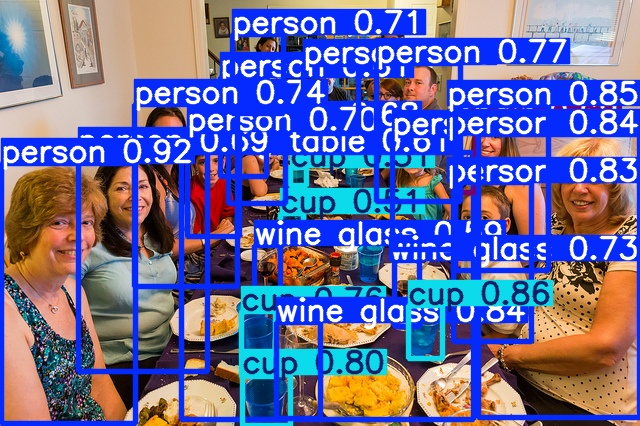

In [46]:
from IPython.display import Image as IPImage

# Adjust the path to your output image
output_image_path = '/content/runs/detect/single_image_detection/results/000000018380.jpg'
IPImage(filename=output_image_path)


In [51]:

weights_path = "/content/yolov5/runs/train/exp/weights/best.pt"
input_image_path = "/content/yolo_dataset/images/val/000000013729.jpg"
output_dir = "/content/runs/detect/single_image_detection"


!python detect.py \
    --weights {weights_path} \
    --source {input_image_path} \
    --conf 0.25 \
    --save-txt \
    --save-conf \
    --project {output_dir} \
    --name results \
    --exist-ok


detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolo_dataset/images/val/000000013729.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/runs/detect/single_image_detection, name=results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/yolo_dataset/images/val/000000013729.jpg: 480x640 4 persons, 1 backpack, 3 bottles, 1 couch, 1 dining table, 1 tv, 1 remote, 330.6ms
Speed: 2.7ms pre-process, 330.6ms inference, 3.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to

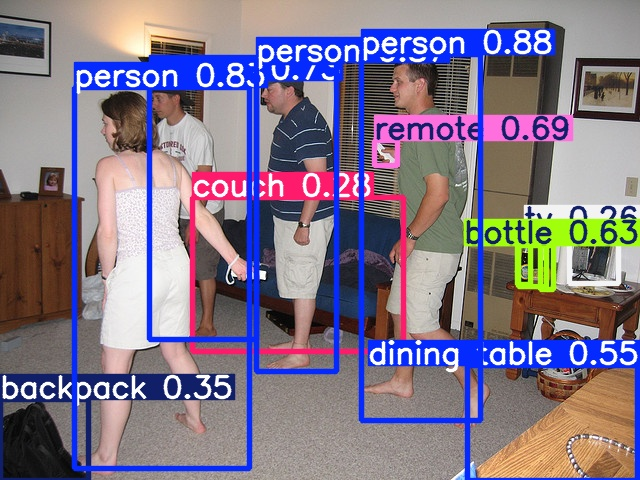

In [52]:
from IPython.display import Image as IPImage

# Adjust the path to your output image
output_image_path = '/content/runs/detect/single_image_detection/results/000000013729.jpg'
IPImage(filename=output_image_path)
